## Table class

Tabela, skupaj z označbo kateri column je primary key

time_col zaenkrat irelevanten

In [2]:
from functools import lru_cache
from typing import Optional

import pandas as pd
from typing_extensions import Self

class Table:
    """
    A table in a database.

    Args:
        name (str): The name of the table.
        df (pandas.DataFrame): The underlying data frame of the table.
        pkey_col (str, optional): The primary key column if it exists.
            (default: :obj:`None`)
        time_col (str, optional): The time column. (default: :obj:`None`)
    """

    def __init__(
        self,
        name: str,
        df: pd.DataFrame,
        pkey_col: Optional[str] = None,
        time_col: Optional[str] = None,
    ):
        self.df = df
        self.name = name
        self.pkey_col = pkey_col
        self.time_col = time_col

    def __repr__(self) -> str:
        """
        Returns a string representation of the Table object.

        Returns:
            str: The string representation of the Table object.
        """
        return (
            f"Table(df=\n{self.df},\n"
            f"  pkey_col={self.pkey_col},\n"
            f"  time_col={self.time_col}"
            f")"
        )

    def __len__(self) -> int:
        """
        Returns the number of rows in the table.

        Returns:
            int: The number of rows in the table.
        """
        return len(self.df)

    def upto(self, time_stamp: pd.Timestamp) -> Self:
        """
        Returns a table with all rows up to the specified time.

        Args:
            time_stamp (pd.Timestamp): The time stamp.

        Returns:
            Table: A new table with all rows up to the specified time.
        """
        if self.time_col is None:
            return self

        return Table(
            df=self.df.query(f"{self.time_col} <= @time_stamp"),
            pkey_col=self.pkey_col,
            time_col=self.time_col,
        )

    @property
    @lru_cache(maxsize=None)
    def min_timestamp(self) -> pd.Timestamp:
        """
        Returns the earliest time in the table.

        Returns:
            pd.Timestamp: The earliest time in the table.

        Raises:
            ValueError: If the table has no time column.
        """
        if self.time_col is None:
            raise ValueError("Table has no time column.")

        return self.df[self.time_col].min()

    @property
    @lru_cache(maxsize=None)
    def max_timestamp(self) -> pd.Timestamp:
        """
        Returns the latest time in the table.

        Returns:
            pd.Timestamp: The latest time in the table.

        Raises:
            ValueError: If the table has no time column.
        """
        if self.time_col is None:
            raise ValueError("Table has no time column.")

        return self.df[self.time_col].max()

## Database class

Array tabel in dictionary, ki shrani pkey-fkey povezave na naslednji način:
`
{
  tabela1 (pkey je znan, ker je tabela1 Table class in ima pkey not) : [povezana_tabela1, fkey_column_name_v_povezani_tabeli1],
  tabela1 : [povezana_tabela2, fkey_column_name_v_povezani_tabeli2],
  tabela2 : [povezana_tabela3, fkey_column_name_v_povezani_tabeli3],
  ...
}
`

Potem pa im funkcije za generiranje nodeov in generiranje edge indexa.

In [3]:
import torch
from torch_geometric.data import HeteroData
import numpy as np

class Database:
    """
    A class representing a database.

    Attributes:
        tables (list): A list of tables in the database.
        table_connections (dict): A dictionary storing table connections.

    Methods:
        add_table: Add a table to the database.
        add_table_connections: Add table connections to the database.
        create_node_array: Create an array of node features.
        add_node_number_to_table: Add a node number to each table.
        create_edge_index: Create the edge index and edge attributes.
        create_graph: Create a PyTorch geometric data object representing the graph.
    """

    def __init__(self):
        self.tables = []
        self.table_connections = {}

    def add_table(self, table):
        """
        Add a table to the database.

        Args:
            table (Table): The table to be added.
        """
        self.tables.append(table)

    def add_table_connections(self, table, foreign_table, foreign_key_col):
        """
        Add table connections to the database.

        Args:
            table (Table): The table to connect.
            foreign_table (Table): The foreign table to connect.
            foreign_key_col (str): The foreign key column name.
        """
        if table in self.table_connections:
            self.table_connections[table].append((foreign_table, foreign_key_col))
        else:
            self.table_connections[table] = [(foreign_table, foreign_key_col)]

    def one_hot_encode_nonnumerical_cols(self, df):
        col_groups = df.columns.to_series().groupby(df.dtypes).groups        
        try:
            non_numeric_cols = col_groups[np.dtype('O')]
            for col in non_numeric_cols:
                encoded_df = pd.get_dummies(df[col], prefix=str(col), dtype=int)
                df = pd.concat([df, encoded_df], axis=1).drop(str(col), axis=1)
        except KeyError:
            pass
        return df
    
    def create_node_array(self):
        """
        Create an array of node features.

        Returns:
            HeteroData: The node features.
        """
        data = HeteroData()
        for table in self.tables:
            oh_table = self.one_hot_encode_nonnumerical_cols(table.df)
            node_features = []
            for row in oh_table.to_numpy():
                node_features.append(row)
                
            data[table.name].x = node_features
        
        return data
    
    def add_node_number_to_table(self):
        """
        Add a node number to each table.
        """
        node_counter = 0
        for table in self.tables:
            table.df['node_nr'] = pd.RangeIndex(start=node_counter + 1, stop=node_counter + len(table.df) + 1)
            node_counter += len(table.df) # Kaj pa če gre za podvajanje? table.df["pkey"].unique()#

    
    def create_edge_index(self, graph):
        """
        Create the edge index and edge attributes.

        Args:
            graph (HeteroData): The graph data.

        Returns:
            HeteroData: The graph data with edge index and attributes.
        """
        
        #TODO: Verjetno je narobe indexing - moralo bi biti pkey-pkey v edge_indexu, brez reindexinga.
        
        for table in self.tables:
            if table in self.table_connections.keys():
                for connection in self.table_connections[table]:
                    foreign_table, foreign_key_col = connection

                    edge_index_transpose = []
                        
                    for row_nr in range(len(table.df)):
                        for row_nr2 in range(len(foreign_table.df)):
                            if table.df[table.pkey_col][row_nr] == foreign_table.df[foreign_key_col][row_nr2]:
                                edge_index_transpose.append([table.df[table.pkey_col][row_nr], foreign_table.df[foreign_table.pkey_col][row_nr2]])
                                edge_index = [[edge_index_transpose[j][i] for j in range(len(edge_index_transpose))] for i in range(len(edge_index_transpose[0]))]
                                edge_index = torch.stack([torch.tensor(edge_index[0]), torch.tensor(edge_index[1])])
                    
                    print(edge_index)
                    graph[table.name, foreign_table.name].edge_index = edge_index
        
        return graph

    def create_graph(self):
        """
        Create a PyTorch geometric data object representing the graph.

        Returns:
            HeteroData: The graph data object.
        """
        node_features = self.create_node_array()
        
        self.add_node_number_to_table()
        
        data = self.create_edge_index(node_features)
        
        return data

In [4]:
# Create three example tables
df1 = pd.DataFrame({'id': [1, 2, 3], 'name': ['Alice', 'Bob', 'Charlie'], 'gender': ['F', 'M', 'M']})
df2 = pd.DataFrame({'id': [1, 2, 3], 'name': ['Martin', 'Rok', 'Franc'], 'gender': ['M', 'NB', 'M']})
df3 = pd.DataFrame({'id': [1, 2, 3, 4], 'age': [25, 30, 35, 20], 'fkey1':[1, 3, 2, 1], 'fkey2':[3, 3, 1, 2]})

df1.to_csv('table1.csv')
df2.to_csv('table2.csv')
df3.to_csv('table3.csv')

# Create Table 1 instance
table1 = Table("tab1", df1, pkey_col='id')
table2 = Table("tab2", df2, pkey_col='id')
table3 = Table("tab3", df3, pkey_col='id')

In [15]:
table = [df1, df2, df3]
for df in table:
    display(df)
    print(df.columns.to_series().groupby(df.dtypes).groups)
    col_groups = df.columns.to_series().groupby(df.dtypes).groups
    if np.dtype('O') in col_groups:
        non_numeric_cols = col_groups[np.dtype('O')]
        for col in non_numeric_cols:
            encoded_df = pd.get_dummies(df[col], prefix=str(col), dtype=int)
            df = pd.concat([df, encoded_df], axis=1).drop(str(col), axis=1)
        display(df)
        for row in df.to_numpy():
            print(row)
    else:
        print("Tabela ima samo numerične stolpce.")

,id,name,gender
0,1,Alice,F
1,2,Bob,M
2,3,Charlie,M


{int64: ['id'], object: ['name', 'gender']}


,id,name_Alice,name_Bob,name_Charlie,gender_F,gender_M
0,1,1,0,0,1,0
1,2,0,1,0,0,1
2,3,0,0,1,0,1


[1 1 0 0 1 0]
[2 0 1 0 0 1]
[3 0 0 1 0 1]


,id,name,gender
0,1,Martin,M
1,2,Rok,NB
2,3,Franc,M


{int64: ['id'], object: ['name', 'gender']}


,id,name_Franc,name_Martin,name_Rok,gender_M,gender_NB
0,1,0,1,0,1,0
1,2,0,0,1,0,1
2,3,1,0,0,1,0


[1 0 1 0 1 0]
[2 0 0 1 0 1]
[3 1 0 0 1 0]


,id,age,fkey1,fkey2
0,1,25,1,3
1,2,30,3,3
2,3,35,2,1
3,4,20,1,2


{int64: ['id', 'age', 'fkey1', 'fkey2']}
Tabela ima samo numerične stolpce.


In [32]:
# Create a Database instance
db = Database()

# Add the tables to the database
db.add_table(table1)
db.add_table(table2)
db.add_table(table3)

# Add table connections
db.add_table_connections(table1, table3, 'fkey1')
db.add_table_connections(table2, table3, 'fkey2')

In [33]:
# Bellow is the same, step-by-step executing funcitons in create_graph()
# edge indices are still explicitly printed for "(physics) testing"
graph = db.create_graph()
graph

tensor([[ 1,  1,  2,  3],
        [ 7, 10,  9,  8]])
tensor([[ 4,  5,  6,  6],
        [ 9, 10,  7,  8]])


HeteroData(
  tab1={ x=[3] },
  tab2={ x=[3] },
  tab3={ x=[4] },
  (tab1, to, tab3)={ edge_index=[2, 4] },
  (tab2, to, tab3)={ edge_index=[2, 4] }
)

In [34]:
node_features = db.create_node_array()
# node_features = torch.tensor(node_features)

In [35]:
node_features['tab1'].x, node_features['tab2'].x, node_features['tab3'].x

([array([1, 1, 1, 0, 0, 1, 0], dtype=int64),
  array([2, 2, 0, 1, 0, 0, 1], dtype=int64),
  array([3, 3, 0, 0, 1, 0, 1], dtype=int64)],
 [array([1, 4, 0, 1, 0, 1, 0], dtype=int64),
  array([2, 5, 0, 0, 1, 0, 1], dtype=int64),
  array([3, 6, 1, 0, 0, 1, 0], dtype=int64)],
 [array([ 1, 25,  1,  3,  7], dtype=int64),
  array([ 2, 30,  3,  3,  8], dtype=int64),
  array([ 3, 35,  2,  1,  9], dtype=int64),
  array([ 4, 20,  1,  2, 10], dtype=int64)])

In [36]:
db.add_node_number_to_table()
graph = db.create_edge_index(node_features)
graph

tensor([[ 1,  1,  2,  3],
        [ 7, 10,  9,  8]])
tensor([[ 4,  5,  6,  6],
        [ 9, 10,  7,  8]])


HeteroData(
  tab1={ x=[3] },
  tab2={ x=[3] },
  tab3={ x=[4] },
  (tab1, to, tab3)={ edge_index=[2, 4] },
  (tab2, to, tab3)={ edge_index=[2, 4] }
)

In [37]:
graph[graph.edge_types[0]].edge_index

tensor([[ 1,  1,  2,  3],
        [ 7, 10,  9,  8]])

In [38]:
# graph.to_homogeneous(), ki bi moral heterogeni graf pretvoriti v homogeni, ne deluje, ker je num_nodes_dict dictionary prazen. Zato ga napolnim na roko (oh well :)).
graph.num_nodes_dict = {'tab1': 3, 'tab2': 3, 'tab3': 4}

In [39]:
graph_hom = graph.to_homogeneous()
graph_hom

Data(
  num_nodes_dict={
    tab1=3,
    tab2=3,
    tab3=4,
  },
  edge_index=[2, 8],
  node_type=[10],
  edge_type=[8]
)

In [41]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

In [42]:
graph_hom.num_nodes

10

In [47]:
G = to_networkx(graph_hom, to_undirected=True)
G.number_of_nodes()
print(G.nodes())
# To bi moralo biti 10, kot je zgoraj

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 16, 15, 14]


In [46]:
graph_hom

Data(
  num_nodes_dict={
    tab1=3,
    tab2=3,
    tab3=4,
  },
  edge_index=[2, 8],
  node_type=[10],
  edge_type=[8]
)

In [44]:
colors = np.array(graph_hom.node_type)
print("len colors = ",len(colors))

len colors =  10


In [45]:
nodes = [n for n in G]
print("len nodes = ",len(nodes))

len nodes =  14


In [24]:
# Ne vem zakaj doda en dodaten node - doda node 0, tako ima edino smisel spodnja slika (ker node iste barve ne smejo biti povezani, prihajajo iz iste tabele in nimajo pk-fk povezav)
colors = np.append(3, np.array(graph_hom.node_type))
colors

array([3, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2], dtype=int64)

ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 11.

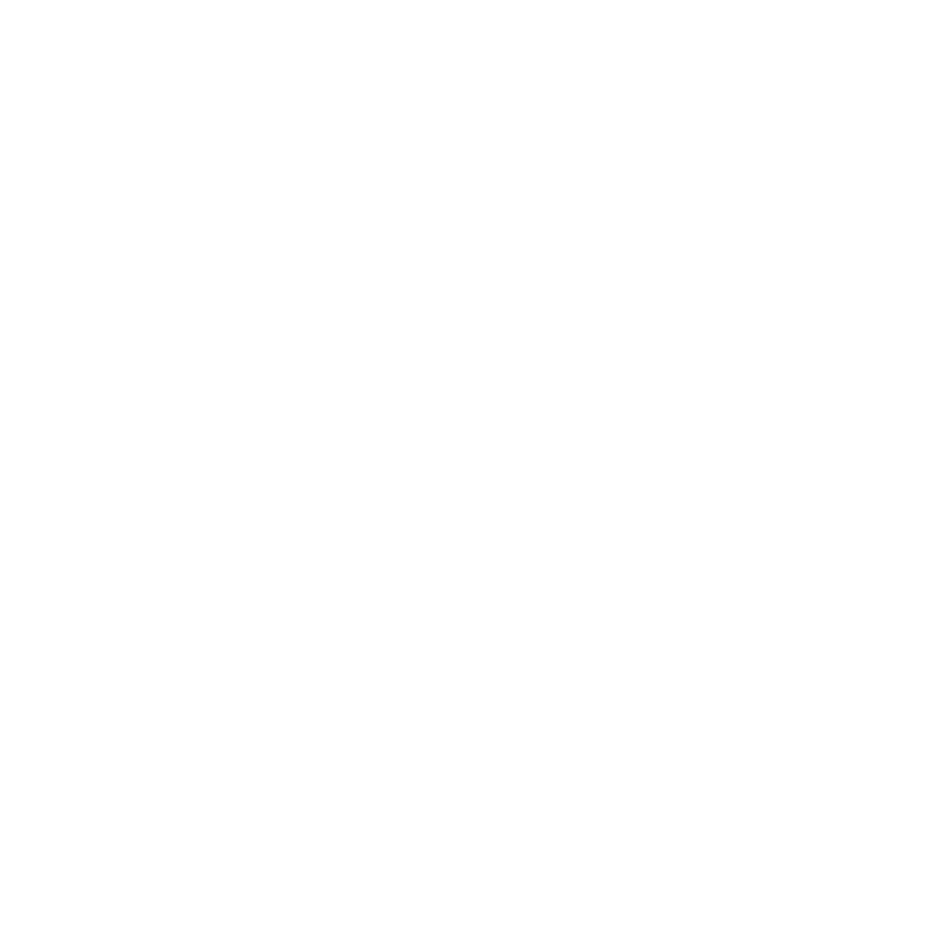

In [26]:
G = to_networkx(graph_hom,to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=colors,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()